In [41]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
137,10Sep__lstm_20dim_1layer_80_lr0.0001_dropout0....,linear_regression,10Sep__lstm_20dim_1layer_80_lr0.0001_dropout0....,,-1,-1,20,1,8,10Sep__lstm_20dim_1layer_80_lr0.0001_dropout0....
165,10Sep_run1_lstm_20dim_10layer_80_lr0.0001_drop...,linear_regression,10Sep_run1_lstm_20dim_10layer_80_lr0.0001_drop...,,-1,-1,20,10,8,10Sep_run1_lstm_20dim_10layer_80_lr0.0001_drop...
143,10Sep_run2_lstm_20dim_10layer_80_lr0.0001_drop...,linear_regression,10Sep_run2_lstm_20dim_10layer_80_lr0.0001_drop...,,-1,-1,20,10,8,10Sep_run2_lstm_20dim_10layer_80_lr0.0001_drop...
164,10Sep_run3_lstm_20dim_10layer_80_lr0.0001_drop...,linear_regression,10Sep_run3_lstm_20dim_10layer_80_lr0.0001_drop...,,-1,-1,20,10,8,10Sep_run3_lstm_20dim_10layer_80_lr0.0001_drop...
140,10Sep_run4_lstm_20dim_10layer_80_lr0.0001_drop...,linear_regression,10Sep_run4_lstm_20dim_10layer_80_lr0.0001_drop...,,-1,-1,20,10,8,10Sep_run4_lstm_20dim_10layer_80_lr0.0001_drop...
...,...,...,...,...,...,...,...,...,...,...
0,pretrained,relu_2nn_regression,Transformer,hidden_layer_size=100,-1,-1,20,12,8,relu_2nn_regression_pretrained
171,pretrained,sparse_linear_regression,Transformer,sparsity=3,-1,-1,20,12,8,sparse_regression_pretrained
175,e198f433-04f9-4e4b-a492-82b1dc625c9c,test,test,,-1,-1,20,10,8,test
174,2d36bb71-76c1-49f4-ba6e-f0a35a42d185,test,test,,-1,100,20,10,8,test


In [43]:
"""
in our case, use linear regression
"""

task = "linear_regression" 
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"

"""
Replace run_id
"""
run_id = "1Sep_10layer_LayerNormF_run5_lstm_20dim_10layer_256_lr0.0001_dropout0.1_curriculumFalse_p_embeddingFalse_layernormFalse"  # if you train more models, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

# Plot pre-computed metrics

1Sep_10layer_LayerNormF_run5_lstm_20dim_10layer_256_lr0.0001_dropout0.1_curriculumFalse_p_embeddingFalse_layernormFalse 1Sep_10layer_LayerNormF_run5_lstm_20dim_10layer_256_lr0.0001_dropout0.1_curriculumFalse_p_embeddingFalse_layernormFalse


100%|██████████| 15/15 [00:00<00:00, 209018.47it/s]

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.9906763076782227, 0.8460330963134766, 0.9351244926452636, 0.7556617736816407, 0.828254508972168, 0.7912309169769287, 0.7587605953216553, 0.7265551090240479, 0.6827831268310547, 0.6413136482238769, 0.5851280212402343, 0.6381239414215087, 0.5491671562194824, 0.5231696605682373, 0.46866474151611326, 0.45210871696472166, 0.43292059898376467, 0.3971531391143799, 0.3947319030761719, 0.36673412322998045, 0.35401644706726076, 0.3579460859298706, 0.32184977531433107, 0.28128459453582766, 0.2945127010345459, 0.2833644151687622, 0.26469595432281495, 0.26888816356658934, 0.22547638416290283, 0.2559505939483643, 0.2204275608062744, 0.22670884132385255, 0.19852994680404662, 0.1855403184890747, 0.19266765117645263, 0.17694228887557983, 0.16290851831436157, 0.16420261859893798, 0.15631320476531982, 0.13692855834960938, 0.144734525680542], 'std': [1.5301239967346192, 1.2204564094543457, 1.436

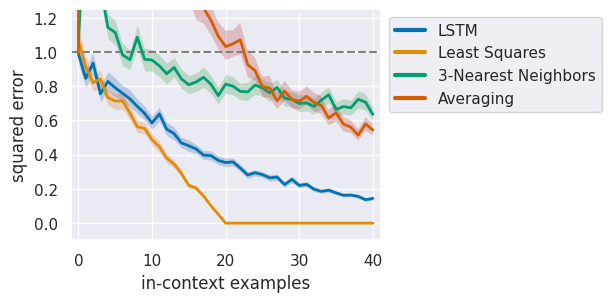

In [46]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task]
# get_run_metrics(run_path)
basic_plot(metrics["standard"], models=models)

plt.show()

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.9833686828613282, 0.9031259536743164, 0.8311312675476075, 0.7054150581359864, 0.7037110805511475, 0.5965323448181152, 0.5659883975982666, 0.47339162826538084, 0.40877065658569334, 0.3670706272125244, 0.3410820722579956, 0.313936185836792, 0.25666065216064454, 0.25715548992156984, 0.2150101661682129, 0.19716980457305908, 0.18466066122055053, 0.1649239778518677, 0.15575605630874634, 0.14378829002380372, 0.11848762035369872, 0.09523800015449524, 0.10546600818634033, 0.08544778823852539, 0.07955085039138794, 0.06793508529663086, 0.06864210367202758, 0.057056772708892825, 0.055050444602966306, 0.05234587788581848, 0.04380311965942383, 0.04405685067176819, 0.0373555064201355, 0.0357207715511322, 0.03337173461914063, 0.034514203667640686, 0.032939597964286804, 0.028492444753646852, 0.03028481900691986, 0.025810250639915468, 0.025203770399093627], 'std': [1.561539077758789, 1.5221055

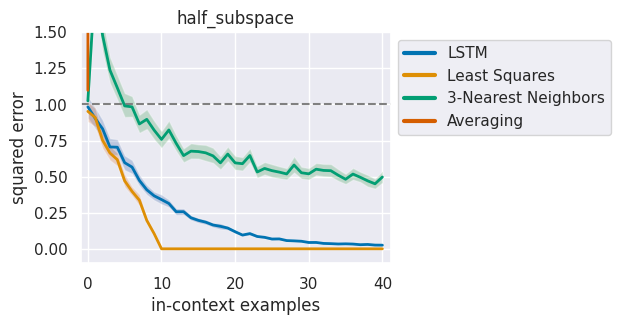

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.9516414642333985, 0.9444052696228027, 0.9180359840393066, 0.8755431175231934, 0.8048792839050293, 0.7893701076507569, 0.832817268371582, 0.6740283012390137, 0.7409651279449463, 0.6979545593261719, 0.6916804313659668, 0.6066950798034668, 0.5800274848937989, 0.574991512298584, 0.5625621318817139, 0.5198423862457275, 0.5158555507659912, 0.4314404010772705, 0.46151232719421387, 0.44458351135253904, 0.4213563919067383, 0.39520041942596434, 0.35810112953186035, 0.35716488361358645, 0.3914093732833862, 0.36154334545135497, 0.3514340877532959, 0.32631332874298097, 0.30831146240234375, 0.2829457759857178, 0.2936335325241089, 0.29150118827819826, 0.27462360858917234, 0.2676181077957153, 0.2959792137145996, 0.2306511402130127, 0.24542613029479982, 0.24064555168151855, 0.2509260654449463, 0.22765166759490968, 0.2278883457183838], 'std': [1.4179978370666504, 1.503013801574707, 1.320919036

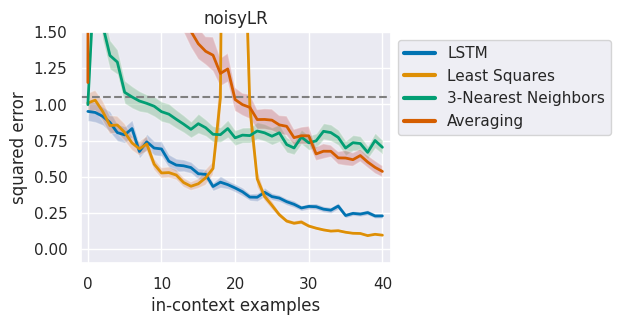

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [1.0188129425048829, 0.961417293548584, 0.9225747108459472, 0.9394984245300293, 0.9868743896484375, 1.043940544128418, 1.0440531730651856, 1.068700408935547, 1.0165566444396972, 1.0565241813659667, 1.0296893119812012, 1.008150005340576, 1.007063102722168, 1.006175708770752, 0.9711602210998536, 0.9577137947082519, 1.012677001953125, 1.0078422546386718, 1.0950258255004883, 1.026075553894043, 0.00046509625390172004, 0.0004803366959095001, 0.0004909678362309932, 0.0005195115692913533, 0.0005101727787405252, 0.0005049778148531914, 0.0004966532811522484, 0.0005324264522641898, 0.0005679264664649964, 0.000551649508997798, 0.0005088843405246735, 0.0005679316818714142, 0.000566026521846652, 0.0005544846411794424, 0.0005770948715507984, 0.0005314013920724392, 0.0005595291033387185, 0.0005918057635426521, 0.000629221647977829, 0.0005906363949179649, 0.000574420252814889], 'std': [1.5340404

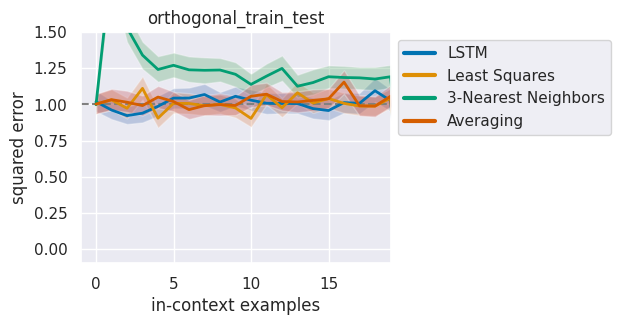

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.9459150314331055, 0.01009986773133278, 0.02038070261478424, 0.03197231888771057, 0.04305434226989746, 0.05665178298950195, 0.0724545657634735, 0.07416977882385253, 0.07992262840270996, 0.10385072231292725, 0.10453250408172607, 0.10600762367248535, 0.10117099285125733, 0.11554867029190063, 0.11830788850784302, 0.1104158878326416, 0.11920394897460937, 0.11102864742279053, 0.1313378095626831, 0.1171884298324585, 0.11675119400024414, 0.11475492715835571, 0.10533583164215088, 0.10500307083129883, 0.10915257930755615, 0.10392167568206787, 0.10150896310806275, 0.09674732089042663, 0.09936076998710633, 0.09946503639221191, 0.10064874887466431, 0.10268038511276245, 0.09003182649612426, 0.0903717815876007, 0.092800772190094, 0.08470104932785034, 0.07989630699157715, 0.08511991500854492, 0.07880994081497192, 0.07019132375717163, 0.07237074375152588], 'std': [1.4037120819091797, 0.028326

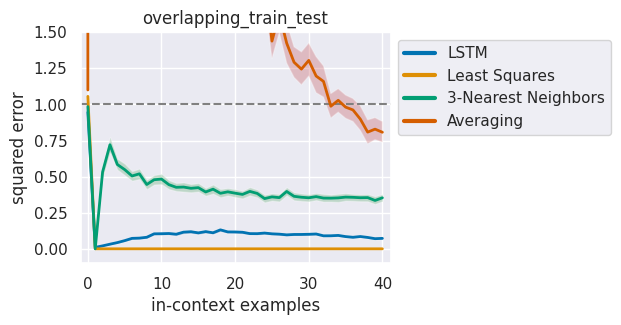

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.9402036666870117, 0.9473631858825684, 0.9943336486816406, 0.8626253128051757, 0.8861895561218261, 0.8061991691589355, 0.8812125205993653, 0.7459585666656494, 0.7965258121490478, 0.7592483520507812, 0.6898599147796631, 0.6869996070861817, 0.6212744235992431, 0.6357759952545166, 0.6277933120727539, 0.63991379737854, 0.6017815589904785, 0.5630379676818847, 0.5912017345428466, 0.5367041110992432, 0.5614844799041748, 0.527517032623291, 0.5253296852111816, 0.4932624340057373, 0.5445722103118896, 0.4431803226470947, 0.49991769790649415, 0.4463414192199707, 0.4545603275299072, 0.45523862838745116, 0.4350956916809082, 0.45080089569091797, 0.41007404327392577, 0.4264866352081299, 0.46732940673828127, 0.42138113975524905, 0.4492486000061035, 0.4460307598114014, 0.46439361572265625, 0.39640419483184813, 0.41884808540344237], 'std': [1.3200909614562988, 1.4226190567016601, 1.5354875564575

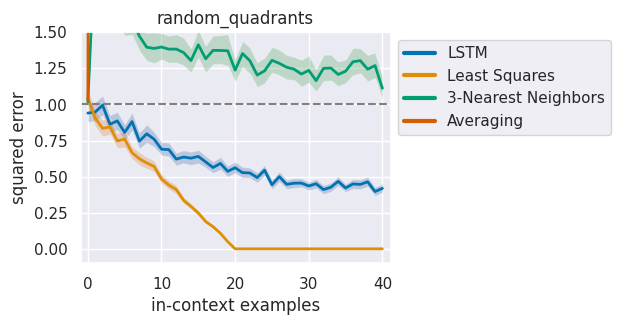

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.11237514019012451, 0.10241681337356567, 0.10811096429824829, 0.09546018838882446, 0.09617692828178406, 0.09014498591423034, 0.09119102358818054, 0.08363035321235657, 0.07917164564132691, 0.08844122886657715, 0.08029063940048217, 0.07869788408279418, 0.07324986457824707, 0.07315338253974915, 0.0701094925403595, 0.07209803462028504, 0.07439698576927185, 0.07150102257728577, 0.06552662849426269, 0.07172568440437317, 0.07034666538238525, 0.06747584342956543, 0.07378228306770325, 0.06989057064056396, 0.07057477235794067, 0.08224207162857056, 0.07602937817573548, 0.07362722158432007, 0.07289118170738221, 0.07697096467018127, 0.07392501235008239, 0.07047359347343445, 0.07847940921783447, 0.07496100664138794, 0.077154541015625, 0.07084528207778931, 0.07172022461891174, 0.0745435357093811, 0.07238824367523193, 0.07151798009872437, 0.07625164389610291], 'std': [0.16810567378997804, 0.1

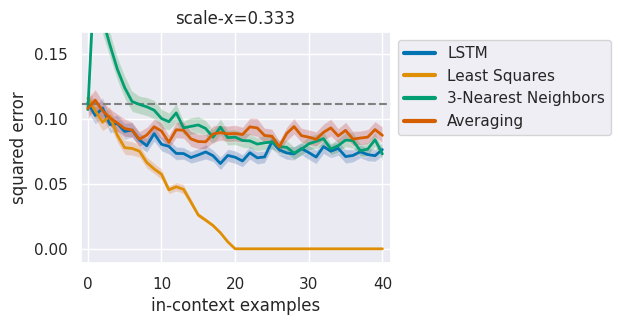

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.25340774059295657, 0.23926949501037598, 0.2542248249053955, 0.2235333204269409, 0.2125154972076416, 0.1974962592124939, 0.19277626276016235, 0.1874092698097229, 0.17712786197662353, 0.17008911371231078, 0.1724586844444275, 0.16449133157730103, 0.15550005435943604, 0.14446868896484374, 0.14041330814361572, 0.13648130893707275, 0.13277502059936525, 0.12296243906021118, 0.11985008716583252, 0.11554853916168213, 0.1099513053894043, 0.11027312278747559, 0.10525782108306884, 0.1028321623802185, 0.09977425336837768, 0.09947888255119323, 0.09529739618301392, 0.09291197657585144, 0.09622797966003419, 0.09317699670791627, 0.08837930560111999, 0.08599056005477905, 0.08211641311645508, 0.07723459005355834, 0.0806315779685974, 0.06887513399124146, 0.0714542031288147, 0.0714232087135315, 0.06773797273635865, 0.06773926019668579, 0.0669991672039032], 'std': [0.3585519790649414, 0.3659746646

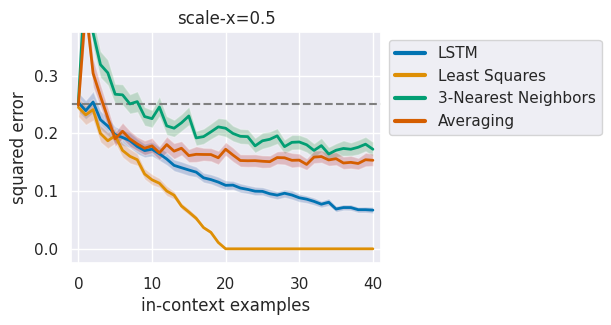

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [4.173351287841797, 3.6456977844238283, 3.6249595642089845, 3.583568572998047, 3.248668670654297, 3.0336313247680664, 3.1431163787841796, 3.0607364654541014, 2.7149709701538085, 2.4616571426391602, 2.5210046768188477, 2.4178516387939455, 2.2481807708740233, 2.3070873260498046, 2.0960210800170898, 1.9398609161376954, 1.961887741088867, 1.864234161376953, 1.8098768234252929, 1.8156452178955078, 1.704256248474121, 1.7349136352539063, 1.5951501846313476, 1.5229475021362304, 1.5139688491821288, 1.3550712585449218, 1.3654040336608886, 1.21630802154541, 1.1540960311889648, 1.197014331817627, 1.2170068740844726, 1.1154078483581542, 1.0560822486877441, 1.034525489807129, 1.0055736541748046, 0.9099671363830566, 0.9721597671508789, 0.8742564201354981, 0.9280783653259277, 0.7546127319335938, 0.846649169921875], 'std': [6.331465148925782, 5.8743549346923825, 5.227617263793945, 5.715657806396

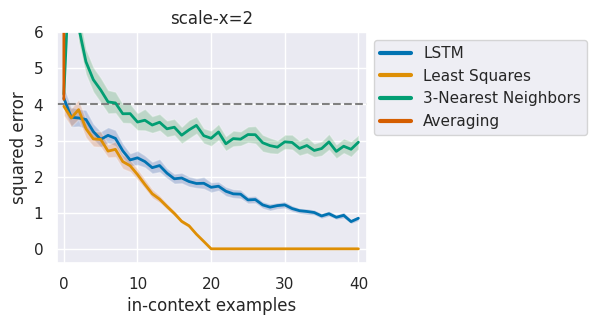

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [9.381886291503907, 8.76721420288086, 8.86489028930664, 8.59173126220703, 8.273954010009765, 7.657988739013672, 7.608388519287109, 6.598677062988282, 7.260505676269531, 6.3754222869873045, 6.298133468627929, 6.014075851440429, 5.591115570068359, 5.650770950317383, 5.637946319580078, 5.07422103881836, 5.26195182800293, 5.224658966064453, 4.635872650146484, 4.469392395019531, 4.703094863891602, 4.649797439575195, 4.350917816162109, 4.158313751220703, 4.636334991455078, 4.299371337890625, 3.958208465576172, 3.670882797241211, 4.183790969848633, 3.5464107513427736, 3.5451286315917967, 3.6264232635498046, 3.5604000091552734, 3.4341899871826174, 3.4524791717529295, 3.211983489990234, 3.7290252685546874, 3.3746353149414063, 3.451289749145508, 3.317186737060547, 3.293416976928711], 'std': [14.741264343261719, 13.57055206298828, 13.406797790527344, 13.812615966796875, 12.941786193847657,

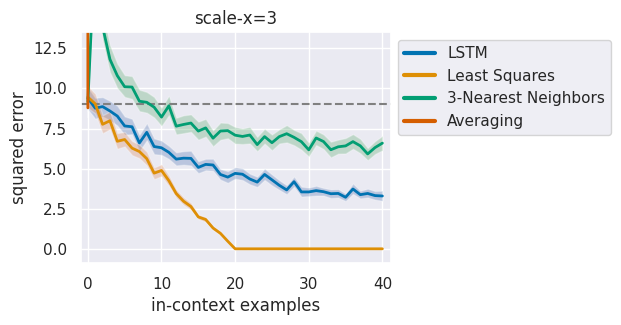

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.11577349901199341, 0.10582304000854492, 0.1054532766342163, 0.09916386604309083, 0.09875072240829467, 0.09283485412597656, 0.08418207168579102, 0.07774008512496948, 0.07575636506080627, 0.07353585362434387, 0.07134411334991456, 0.06474835276603699, 0.06361902356147767, 0.06216654181480408, 0.06338844299316407, 0.05579630136489868, 0.05542069673538208, 0.050519859790802, 0.04819068014621734, 0.04526899456977844, 0.038609209656715396, 0.04371870458126068, 0.038838529586791994, 0.03655677437782288, 0.03867166936397552, 0.037012693285942075, 0.035186901688575745, 0.031082344055175782, 0.02884329855442047, 0.02987334132194519, 0.03229316473007202, 0.02844858169555664, 0.026475507020950317, 0.0264702171087265, 0.024667815864086153, 0.024802860617637635, 0.02329464852809906, 0.023776645958423614, 0.021056704223155975, 0.022090832889080047, 0.021111316978931427], 'std': [0.1858894944

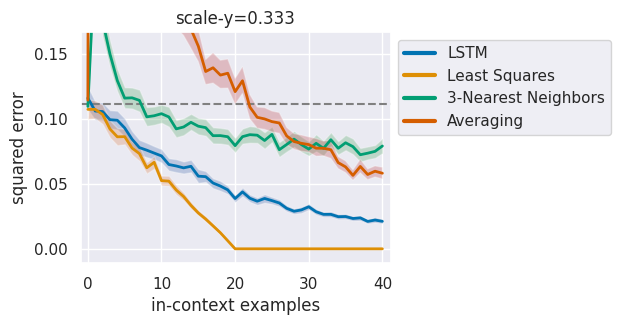

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [0.23301417827606202, 0.24808940887451172, 0.24748609066009522, 0.20784449577331543, 0.20592193603515624, 0.1981497049331665, 0.1800595998764038, 0.1881506323814392, 0.16150505542755128, 0.15987863540649414, 0.15925658941268922, 0.1446794390678406, 0.14660156965255738, 0.13703854084014894, 0.11853697299957275, 0.11548039913177491, 0.11902163028717042, 0.10200004577636719, 0.10105998516082763, 0.09771015048027039, 0.09453774690628051, 0.09046369791030884, 0.08269892930984497, 0.07384656667709351, 0.0759872019290924, 0.07365556359291077, 0.06762956976890563, 0.06370218992233276, 0.06412807703018189, 0.05988868474960327, 0.05954611897468567, 0.053640729188919066, 0.053059440851211545, 0.04874858856201172, 0.04903482794761658, 0.05151909589767456, 0.04633584022521973, 0.04256974160671234, 0.040443801879882814, 0.04115232527256012, 0.03665814995765686], 'std': [0.33791778087615965, 0

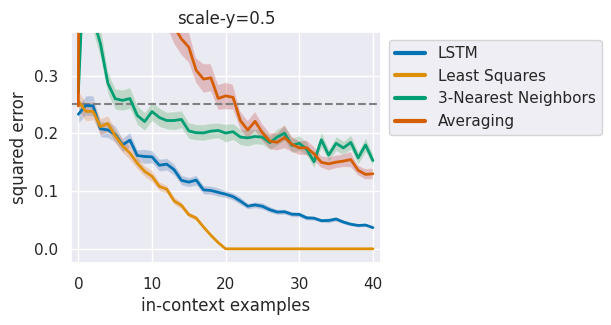

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [3.904235076904297, 3.665754699707031, 3.5717342376708983, 3.4762535095214844, 3.425537109375, 3.0253368377685548, 3.063239097595215, 2.683112144470215, 2.5427860260009765, 2.5343864440917967, 2.524220275878906, 2.4178241729736327, 2.3490474700927733, 2.2347591400146483, 1.9919973373413087, 1.7835210800170898, 1.8967357635498048, 1.7766437530517578, 1.6202157974243163, 1.6007635116577148, 1.626796340942383, 1.5165812492370605, 1.462153148651123, 1.3669219970703126, 1.4514317512512207, 1.3133503913879394, 1.2863085746765137, 1.2505385398864746, 1.0842015266418457, 1.2451022148132325, 1.1130284309387206, 1.0104052543640136, 1.0289299011230468, 0.9801065444946289, 1.0242671012878417, 0.9790334701538086, 0.937959098815918, 0.8681767463684082, 1.0187891006469727, 0.9243200302124024, 0.9329028129577637], 'std': [5.952590560913086, 6.472354888916016, 5.423429489135742, 5.54016036987304

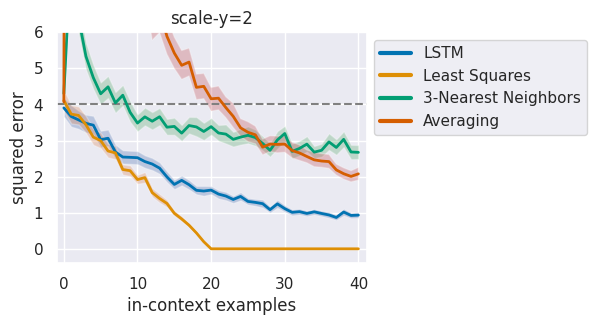

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [8.287120056152343, 8.81722183227539, 8.183753967285156, 7.9545753479003904, 8.068513488769531, 7.1285400390625, 6.417585754394532, 6.429566192626953, 6.580247497558593, 5.774457550048828, 5.980309295654297, 5.580635452270508, 5.571464920043946, 5.447196197509766, 5.2022655487060545, 4.702117538452148, 4.563903045654297, 4.591551971435547, 4.646333694458008, 4.661040496826172, 4.3956958770751955, 4.2693534851074215, 4.175418090820313, 4.2292724609375, 4.3724220275878904, 4.145529937744141, 4.203741455078125, 4.046796417236328, 3.8469173431396486, 3.9110130310058593, 4.043813323974609, 4.1606498718261715, 4.065673446655273, 3.9601158142089843, 3.7520294189453125, 4.047048187255859, 3.8941749572753905, 3.648418426513672, 3.697484588623047, 4.025778961181641, 3.6474742889404297], 'std': [12.924356079101562, 13.286032104492188, 12.950454711914062, 11.78826446533203, 12.6196968078613

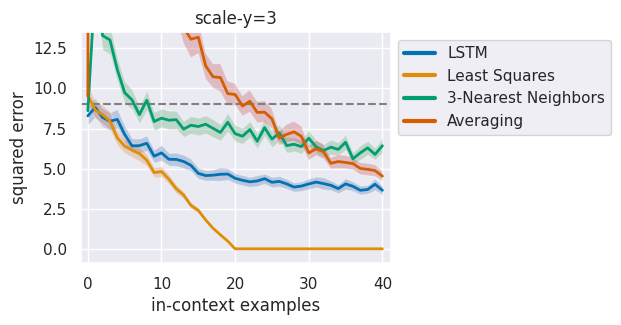

DEBUG: models ['LSTM', 'Least Squares', '3-Nearest Neighbors', 'Averaging']
DEBUG: metrics {'LSTM': {'mean': [1.0529211044311524, 0.7588214874267578, 0.49706602096557617, 0.3942422389984131, 0.35625457763671875, 0.3159590244293213, 0.3185765027999878, 0.2784538745880127, 0.23928213119506836, 0.23810367584228515, 0.21765201091766356, 0.20260109901428222, 0.19897615909576416, 0.18874151706695558, 0.1913220167160034, 0.17002044916152953, 0.16481107473373413, 0.16784404516220092, 0.1686693787574768, 0.1454579472541809, 0.1634413480758667, 0.15525436401367188, 0.13805122375488282, 0.13209456205368042, 0.12458446025848388, 0.13610445261001586, 0.14006744623184203, 0.12918872833251954, 0.125092613697052, 0.12240802049636841, 0.12027583122253419, 0.13106193542480468, 0.11966499090194702, 0.11446994543075562, 0.11304185390472413, 0.11046398878097534, 0.10800309181213379, 0.13061519861221313, 0.11031129360198974, 0.09511333703994751, 0.10039875507354737], 'std': [2.2194183349609373, 1.5016750335

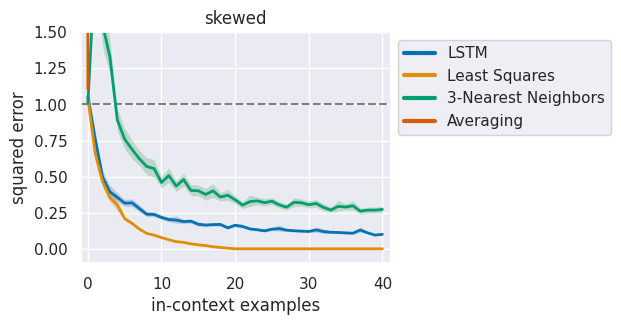

In [ ]:
# plot any OOD metrics
for name, metric in metrics.items():
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    plt.show()

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [ ]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [ ]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

use first n layer: 10
use partial model: False


In [ ]:
task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)

In [ ]:
with torch.no_grad():

    pred = model(xs, ys)

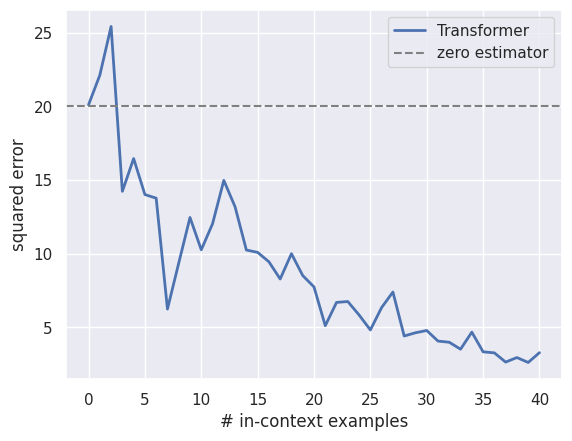

In [ ]:
metric = task.get_metric()
loss = metric(pred, ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [ ]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)
with torch.no_grad():
    pred2 = model(xs2, ys2)

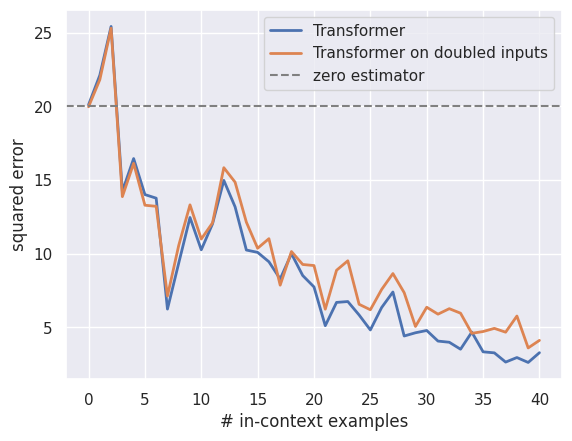

In [ ]:
loss2 = metric(pred2, ys2).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.